### EDA, Preprocessing, and Tweet Analysis Notebook

In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import nltk
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import seaborn as sns

from nltk.stem.wordnet import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from applesauce import model_scoring, cost_benefit_analysis, evaluate_model
from applesauce import model_opt, single_model_opt

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
print(stopwords)
print(nlp.Defaults.stop_words)

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>
{'none', 'hereafter', 'we', 'anyhow', 'how', 'such', 'before', 'enough', 'towards', 'do', 'must', 'everything', 'done', 'now', 'this', 'whole', 'beyond', 'whom', 'however', "'re", 'have', 'too', 'our', 'toward', 'somewhere', 'therein', 'themselves', 'two', 'empty', 'hereupon', 'until', 'move', 'anything', 'a', 'that', 'used', 'front', 'might', 'nine', 'whence', 'above', 'during', 'at', 'him', 'using', 'but', 'yourself', 'therefore', 'often', 'say', 'been', 'various', 'please', 'doing', 'thereupon', 'beside', 'every', 'really', 'four', '‘re', 'someone', 'give', 'several', 'never', 'these', 'only', 'into', 'quite', 'yourselves', 'there', 'thus', 'more', 'elsewhere', 'besides', 'in', 'whatever', 'became', 'fifteen', 'of', 'latter', 'among', 'anywhere', 'may', 'who', 'hers', 'with', 'call', 'whereupon', 'others', 'hence', 'mostly', 'i', 'your', 'about', 'along', 'becoming', 'across', 'were', 'though', 'ours', 'through', 'be

In [4]:
df = pd.read_csv('data/product_tweets.csv',encoding='latin1')

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [7]:
df = df.rename(columns= {'is_there_an_emotion_directed_at_a_brand_or_product'
                         :'Emotion','emotion_in_tweet_is_directed_at': 'Platform'})

In [8]:
df = df.rename(columns= {'tweet_text': 'Tweet'})

In [9]:
df.head() # want to remove the @'name' in the tweet 

,Tweet,Platform,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [10]:
df_dummify = pd.get_dummies(df['Emotion'])

In [11]:
df_dummify.head()

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


In [12]:
df_dummify.sum() # class bias 

I can't tell                           156
Negative emotion                       570
No emotion toward brand or product    5389
Positive emotion                      2978
dtype: int64

In [13]:
df.info()
df = pd.merge(df, df_dummify, how='outer',on=df.index) # ran this code, dummify emotion data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet     9092 non-null   object
 1   Platform  3291 non-null   object
 2   Emotion   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9092
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   key_0                               9093 non-null   int64 
 1   Tweet                               9092 non-null   object
 2   Platform                            3291 non-null   object
 3   Emotion                             9093 non-null   object
 4   I can't tell                        9093 non-null   uint8 
 5   Negative emotion                    9093 non-null   uint8 
 6   No emotion toward brand or product  9093 non-null   uint8 
 7   Positive emotion                    9093 non-null   uint8 
dtypes: int64(1), object(3), uint8(4)
memory usage: 390.7+ KB


In [15]:
df.head()

,key_0,Tweet,Platform,Emotion,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [16]:
df = df.rename(columns = {"I can't tell": "Uncertain", 'Negative emotion': 'Negative'
                          , 'No emotion toward brand or product': 'No Emotion'
                          , 'Positive emotion':'Positive'})

In [17]:
df = df.drop(columns='key_0')
df.head()

,Tweet,Platform,Emotion,Uncertain,Negative,No Emotion,Positive
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [18]:
corpus = list(df['Tweet'])
corpus[:10]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 nan,
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.l

### Tokenize the Words

In [19]:
tokenz = word_tokenize(','.join(str(v) for v in corpus))

In [20]:
tokenz[:10]

['.', '@', 'wesley83', 'I', 'have', 'a', '3G', 'iPhone', '.', 'After']

### Create Stopwords List

In [21]:
stopword_list = list(nlp.Defaults.stop_words)
len(nlp.Defaults.stop_words)

326

In [22]:
stopword_list

['none',
 'hereafter',
 'we',
 'anyhow',
 'how',
 'such',
 'before',
 'enough',
 'towards',
 'do',
 'must',
 'everything',
 'done',
 'now',
 'this',
 'whole',
 'beyond',
 'whom',
 'however',
 "'re",
 'have',
 'too',
 'our',
 'toward',
 'somewhere',
 'therein',
 'themselves',
 'two',
 'empty',
 'hereupon',
 'until',
 'move',
 'anything',
 'a',
 'that',
 'used',
 'front',
 'might',
 'nine',
 'whence',
 'above',
 'during',
 'at',
 'him',
 'using',
 'but',
 'yourself',
 'therefore',
 'often',
 'say',
 'been',
 'various',
 'please',
 'doing',
 'thereupon',
 'beside',
 'every',
 'really',
 'four',
 '‘re',
 'someone',
 'give',
 'several',
 'never',
 'these',
 'only',
 'into',
 'quite',
 'yourselves',
 'there',
 'thus',
 'more',
 'elsewhere',
 'besides',
 'in',
 'whatever',
 'became',
 'fifteen',
 'of',
 'latter',
 'among',
 'anywhere',
 'may',
 'who',
 'hers',
 'with',
 'call',
 'whereupon',
 'others',
 'hence',
 'mostly',
 'i',
 'your',
 'about',
 'along',
 'becoming',
 'across',
 'were',
 '

In [23]:
stopword_list.extend(string.punctuation)

In [24]:
len(stopword_list)

358

In [25]:
stopword_list.extend(stopwords.words('english'))

In [26]:
len(stopword_list)

537

In [27]:
additional_punc = ['“','”','...',"''",'’','``','https','rt','\.+']
stopword_list.extend(additional_punc)
stopword_list[-10:]

["wouldn't", '“', '”', '...', "''", '’', '``', 'https', 'rt', '\\.+']

### Remove stopwords and additional punctuation from the data

In [28]:
stopped_tokenz = [word.lower() for word in tokenz if word.lower() not in stopword_list]

In [29]:
freq = FreqDist(stopped_tokenz)
freq.most_common(50)

[('sxsw', 9418),
 ('mention', 7120),
 ('link', 4313),
 ('google', 2593),
 ('ipad', 2432),
 ('apple', 2301),
 ('quot', 1696),
 ('iphone', 1516),
 ('store', 1472),
 ('2', 1114),
 ('new', 1090),
 ('austin', 959),
 ('amp', 836),
 ('app', 810),
 ('circles', 658),
 ('launch', 653),
 ('social', 647),
 ('android', 574),
 ('today', 574),
 ('network', 465),
 ('ipad2', 457),
 ('pop-up', 420),
 ('line', 405),
 ('free', 387),
 ('called', 361),
 ('party', 346),
 ('sxswi', 340),
 ('mobile', 338),
 ('major', 301),
 ('like', 290),
 ('time', 271),
 ('temporary', 264),
 ('opening', 257),
 ('possibly', 240),
 ('people', 226),
 ('downtown', 225),
 ('apps', 224),
 ('great', 222),
 ('maps', 219),
 ('going', 217),
 ('check', 216),
 ('mayer', 214),
 ('day', 214),
 ('open', 210),
 ('popup', 209),
 ('need', 205),
 ('marissa', 189),
 ('got', 185),
 ('w/', 182),
 ('know', 180)]

### Lemmatize the Data and use Regex to find and remove URL's, Tags, other misc

In [30]:
additional_misc = ['sxsw','mention',r'[a-zA-Z]+\'?s]',r"(http[s]?://\w*\.\w*/+\w+)"
                   ,r'\#\w*',r'RT [@]?\w*:',r'\@\w*',r"\d$",r"^\d"
                   ,r"([a-zA-Z]+(?:'[a-z]+)?)",r'\d.',r'\d','RT',r'^http[s]?','za'] #[A-Z]{2,20} remove caps like MAGA and CDT
stopword_list.extend(additional_misc)
stopword_list.extend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [31]:
lemmatizer = WordNetLemmatizer()

In [32]:
clean_stopped_tokenz = [word.lower() for word in stopped_tokenz if word not in stopword_list]
clean_lemmatized_tokenz = [lemmatizer.lemmatize(word.lower()) for word in stopped_tokenz if word not in stopword_list]

In [33]:
freq_clean_lemma = FreqDist(clean_lemmatized_tokenz)
freq_lemma = freq_clean_lemma.most_common(5000)
freq_lemma2 = freq_clean_lemma.most_common(25)

In [34]:
total_word_count = len(clean_lemmatized_tokenz)

In [35]:
lemma_word_count = sum(freq_clean_lemma.values()) # just a number

In [36]:
for word in freq_lemma2:
    normalized_freq = word[1] / lemma_word_count
    print(word, "----", "{:.3f}".format(normalized_freq*100),"%")

('link', 4324) ---- 5.004 %
('google', 2594) ---- 3.002 %
('ipad', 2432) ---- 2.814 %
('apple', 2304) ---- 2.666 %
('quot', 1696) ---- 1.963 %
('iphone', 1516) ---- 1.754 %
('store', 1511) ---- 1.749 %
('new', 1090) ---- 1.261 %
('austin', 960) ---- 1.111 %
('amp', 836) ---- 0.967 %
('app', 810) ---- 0.937 %
('launch', 691) ---- 0.800 %
('circle', 673) ---- 0.779 %
('social', 647) ---- 0.749 %
('android', 574) ---- 0.664 %
('today', 574) ---- 0.664 %
('network', 473) ---- 0.547 %
('ipad2', 457) ---- 0.529 %
('line', 442) ---- 0.512 %
('pop-up', 422) ---- 0.488 %
('free', 387) ---- 0.448 %
('party', 386) ---- 0.447 %
('called', 361) ---- 0.418 %
('mobile', 340) ---- 0.393 %
('sxswi', 340) ---- 0.393 %


In [37]:
# from wordcloud import WordCloud

# ## Initalize a WordCloud with our stopwords_list and no bigrams
# wordcloud = WordCloud(stopwords=stopword_list,collocations=False)

# ## Generate wordcloud from stopped_tokens
# wordcloud.generate(','.join(clean_lemmatized_tokenz))

# ## Plot with matplotlib
# plt.figure(figsize = (12, 12), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis('off')

In [38]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [39]:
word_pairs = pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(20)
word_pairs

,Word,Freq
0,"(apple, store)",0.006920
1,"(social, network)",0.005277
2,"(new, social)",0.004837
3,"(google, launch)",0.003912
4,"(link, google)",0.003877
5,"(network, called)",0.003784
6,"(called, circle)",0.003634
7,"(today, link)",0.003437
8,"(major, new)",0.003356
9,"(iphone, app)",0.003333


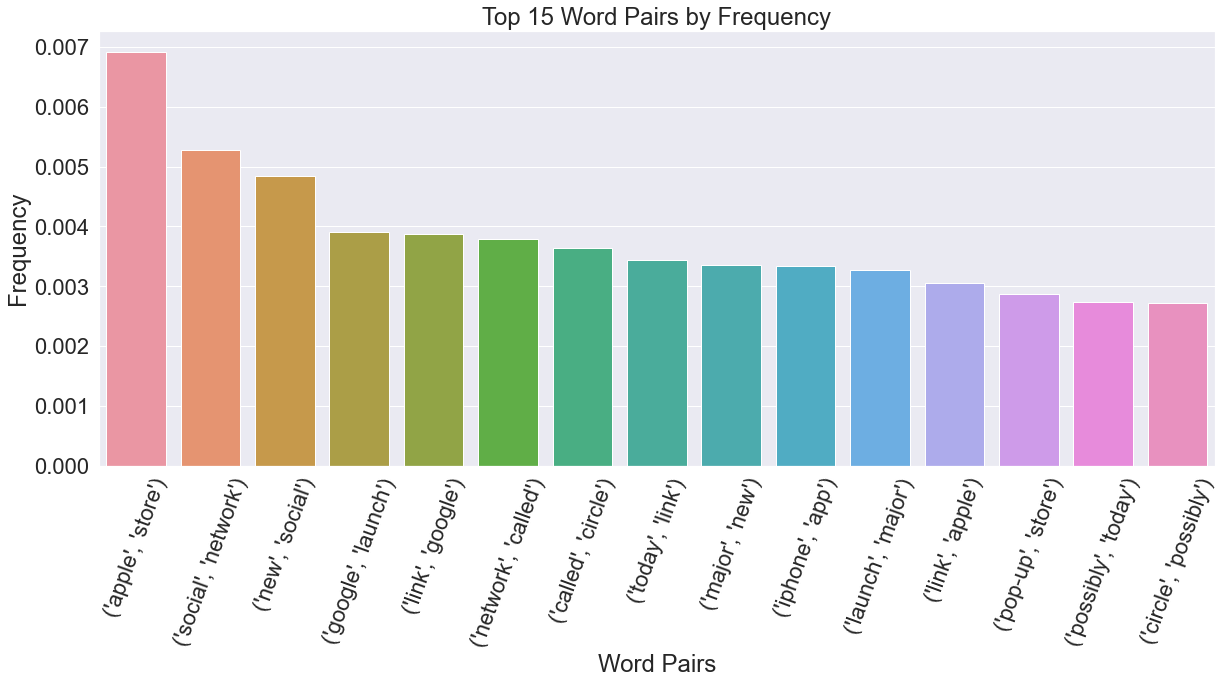

In [75]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=word_pairs.head(15)['Word'], y=word_pairs.head(15)['Freq'], palette=palette)
ax.set(xlabel="Word Pairs",ylabel="Frequency")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by Frequency')
plt.show()

In [41]:
tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweet_pmi_finder.apply_freq_filter(5)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [42]:
PMI_list = pd.DataFrame(tweet_pmi_scored, columns=["Words","PMI"]).head(20)
PMI_list

,Words,PMI
0,"(û÷sxsw, goûª)",14.076983
1,"(jc, penney)",13.813948
2,"(knitted, staircase)",13.813948
3,"(naomi, campbell)",13.813948
4,"(parking, 5-10)",13.813948
5,"(pauly, celebs)",13.813948
6,"(98, accuracy)",13.591556
7,"(aron, pilhofer)",13.591556
8,"(charlie, sheen)",13.591556
9,"(lynn, teo)",13.591556


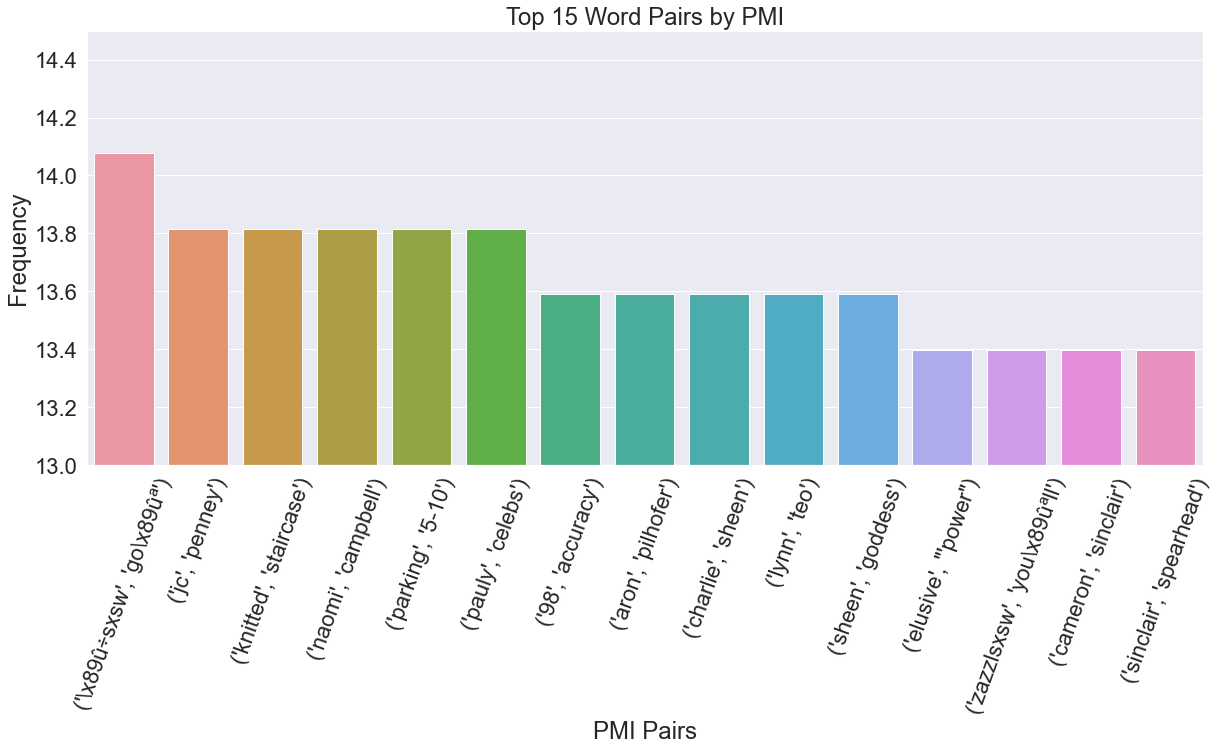

In [43]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=PMI_list.head(15)['Words'], y=PMI_list.head(15)['PMI'], palette=palette)
ax.set(xlabel="PMI Pairs",ylabel="Frequency")
plt.ylim([13,14.5])
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by PMI')
plt.show()

In [44]:
df1 = df
df.head()

,Tweet,Platform,Emotion,Uncertain,Negative,No Emotion,Positive
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [45]:
df1 = df1.drop(columns=['Uncertain','No Emotion'])
# Turn negative and positive columns into one column of just negatives and positive.
df1 = df1[df1['Emotion'] != "No emotion toward brand or product"]
df1 = df1[df1['Emotion'] != "I can't tell"]
df1 = df1.drop(columns='Negative')
df1 = df1.rename(columns={'Positive': 'Positive_Bin'})
df1.head()

,Tweet,Platform,Emotion,Positive_Bin
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


### Create upsampled data, train and test sets


In [46]:
from sklearn.utils import resample

In [47]:
df_majority = df1.loc[df1['Positive_Bin']==1]
df_minority = df1.loc[df1['Positive_Bin']==0]

In [48]:
df_minority.shape

(570, 4)

In [49]:
df_majority.shape

(2978, 4)

In [50]:
df_min_sample = resample(df_minority, replace=True, n_samples=1000, random_state=42)

In [51]:
df_maj_sample = resample(df_majority, replace=True, n_samples=2500, random_state=42)

In [52]:
df_upsampled = pd.concat([df_min_sample, df_maj_sample], axis=0)
df_upsampled.shape

(3500, 4)

In [53]:
X, y = df_upsampled['Tweet'], df_upsampled['Positive_Bin']

### Train/Test Split

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [55]:
scaler_object = MaxAbsScaler()

In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         3548 non-null   object
 1   Platform      3191 non-null   object
 2   Emotion       3548 non-null   object
 3   Positive_Bin  3548 non-null   uint8 
dtypes: object(3), uint8(1)
memory usage: 114.3+ KB


In [57]:
y_train.value_counts(0)
y_test.value_counts(1)

2020-12-17 13:23:40,433 : INFO : NumExpr defaulting to 8 threads.


1    0.683429
0    0.316571
Name: Positive_Bin, dtype: float64

### Vectorize, Lemmatize with Count Vectorizer and Tf Idf

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

tokenizer = nltk.TweetTokenizer(preserve_case=False)

vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopword_list,decode_error='ignore')

In [59]:
# for row in X_train:
#     for word in row:
#         lemmatizer.lemmatize(X_train[row][word])
# return X_train[word][row]

In [60]:
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [":'[", ':/', 'a-z', 'a-za-z', 'http', 'n', 'w', '‘'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [61]:
ran_for = RandomForestClassifier(class_weight='balanced')
model = ran_for.fit(X_train_count, y_train)

In [62]:
y_hat_test = model.predict(X_test_count)

### Evaluate Models

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       277
           1       0.93      0.98      0.95       598

    accuracy                           0.93       875
   macro avg       0.94      0.91      0.92       875
weighted avg       0.93      0.93      0.93       875



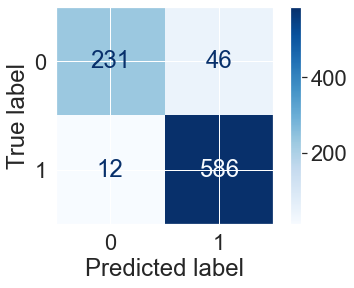

In [63]:
evaluate_model(y_test, y_hat_test, X_test_count,clf=model) # 1 denotes Positive Tweet

In [64]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                    stop_words=stopword_list,decode_error='ignore')

In [65]:
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)
print(X_train_tf_idf.shape)
print(y_train.shape)

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [":'[", ':/', 'a-z', 'a-za-z', 'http', 'n', 'w', '‘'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(2625, 4295)
(2625,)


In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
ran_for = RandomForestClassifier(class_weight='balanced')
model_tf_idf = ran_for.fit(X_train_tf_idf,y_train)

In [68]:
y_hat_tf_idf = model_tf_idf.predict(X_test_count)

              precision    recall  f1-score   support

           0       0.87      0.64      0.74       277
           1       0.85      0.96      0.90       598

    accuracy                           0.86       875
   macro avg       0.86      0.80      0.82       875
weighted avg       0.86      0.86      0.85       875



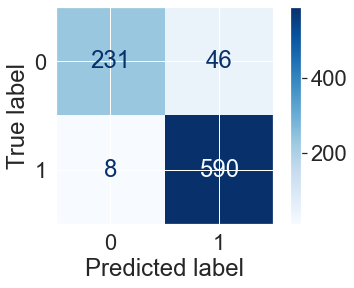

In [69]:
evaluate_model(y_test, y_hat_tf_idf, X_test_tf_idf,clf=model_tf_idf) # slightly better performance

Accuracy Score:  0.936
Precision Score:  0.9234375
Recall Score:  0.9882943143812709
F1 Score:  0.9547657512116317
RandomForestClassifier()   0.936


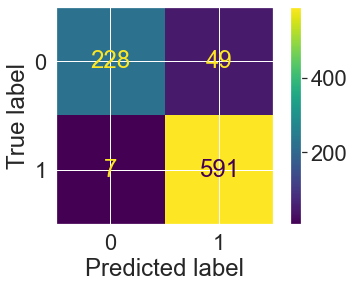

Accuracy Score:  0.9325714285714286
Precision Score:  0.9178294573643411
Recall Score:  0.9899665551839465
F1 Score:  0.9525341914722445
RandomForestClassifier()   0.9325714285714286


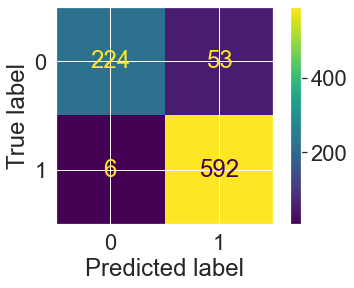

Accuracy Score:  0.9302857142857143
Precision Score:  0.9175738724727839
Recall Score:  0.9866220735785953
F1 Score:  0.9508460918614021
RandomForestClassifier()   0.9302857142857143


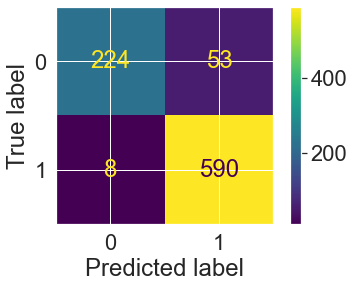

In [70]:
ran_for = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()

models = [ran_for, ada_clf, gb_clf]

for model in models:
    single_model_opt(ran_for, X_train_count, y_train, X_test_count, y_test)

Accuracy Score:  0.9325714285714286
Precision Score:  0.9178294573643411
Recall Score:  0.9899665551839465
F1 Score:  0.9525341914722445
RandomForestClassifier()   0.9325714285714286


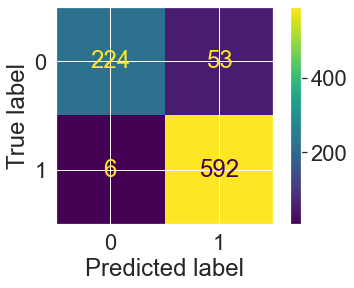

Accuracy Score:  0.9291428571428572
Precision Score:  0.9148606811145511
Recall Score:  0.9882943143812709
F1 Score:  0.95016077170418
RandomForestClassifier()   0.9291428571428572


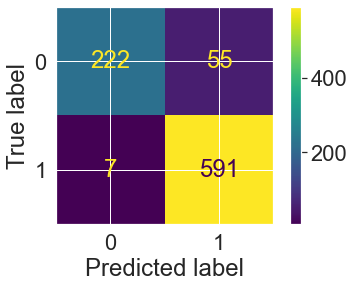

Accuracy Score:  0.9348571428571428
Precision Score:  0.9167950693374423
Recall Score:  0.9949832775919732
F1 Score:  0.9542902967121091
RandomForestClassifier()   0.9348571428571428


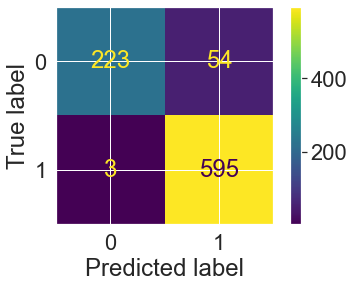

In [71]:
for model in models:
    single_model_opt(ran_for, X_train_tf_idf, y_train, X_test_tf_idf, y_test)

In [72]:
tf_idf_vectorizer.get_feature_names()

['##sxsw',
 '#10',
 '#106',
 '#11ntc',
 '#1406-08',
 '#15slides',
 '#310409h2011',
 '#4sq',
 '#911tweets',
 '#abacus',
 '#accesssxsw',
 '#accordion',
 '#aclu',
 '#adam',
 '#addictedtotheinterwebs',
 '#adpeopleproblems',
 '#agchat',
 '#agileagency',
 '#agnerd',
 '#allhat3',
 '#alwayshavingtoplugin',
 '#amateurhour',
 '#android',
 "#android's",
 '#androidsxsw',
 '#angrybirds',
 '#annoying',
 '#app',
 '#appcircus',
 '#apple',
 "#apple's",
 '#apple_store',
 '#appleatxdt',
 '#applefanatic',
 '#appletakingoverworld',
 '#apps',
 '#appstore',
 '#art',
 '#assistivetech',
 '#at',
 '#atl',
 '#att',
 '#atx',
 '#atzip',
 '#augcomm',
 '#aus',
 '#austin',
 '#austincrowd',
 '#austinwins',
 '#ausxsw',
 '#bankinnovate',
 '#bankinnovation',
 '#barrydiller',
 '#batterykiller',
 '#battlela',
 '#bavcid',
 '#bawling',
 '#bbq',
 '#behance',
 '#bestappever',
 '#betainvites',
 '#bettercloud',
 '#bettersearch',
 '#betterthingstodo',
 '#beyondwc',
 '#bing',
 '#bizzy',
 '#blackberry',
 '#boom',
 '#booyah',
 '#brai

In [73]:
importance = pd.Series(ran_for.feature_importances_,index=tf_idf_vectorizer.get_feature_names())
importance = pd.DataFrame(importance).sort_values(by=0,ascending=False)

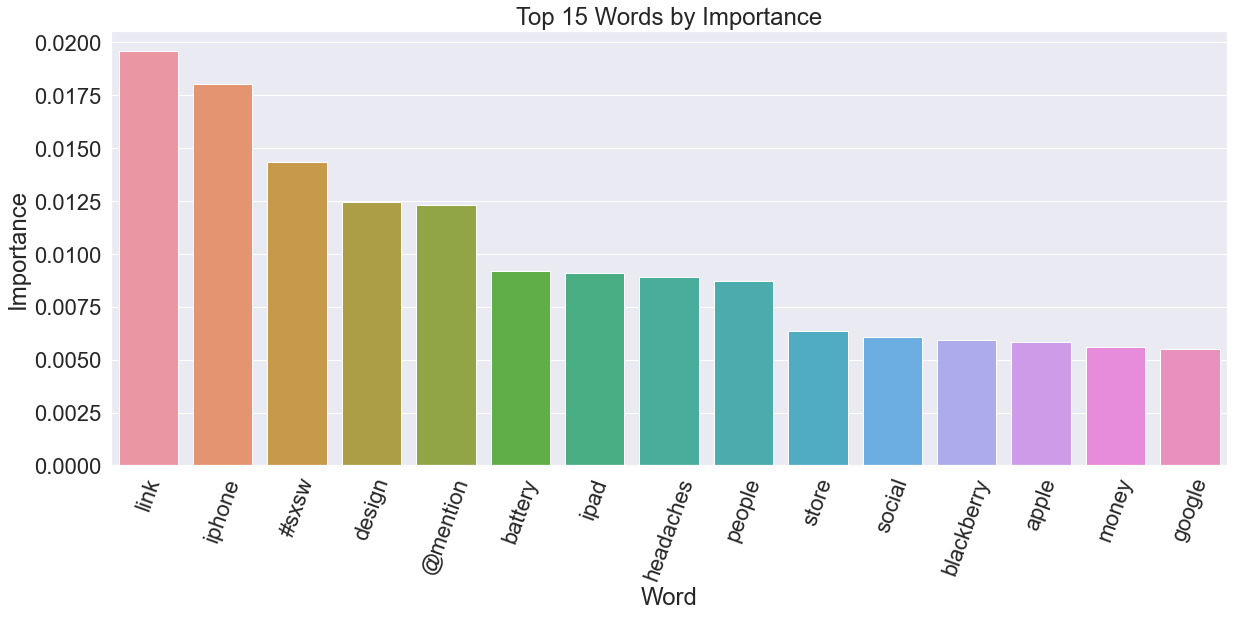

In [80]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=importance.head(15).index, y=importance.head(15)[0], palette=palette)
ax.set(xlabel="Word",ylabel="Importance")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Words by Importance')
plt.show() 

In [81]:
vectorizer = CountVectorizer()
tf_transform = TfidfTransformer(use_idf=True)

In [82]:
text_pipe = Pipeline(steps=[
    ('count_vectorizer',vectorizer),
    ('tf_transformer',tf_transform)])

In [83]:
RandomForestClassifier(class_weight='balanced')

RandomForestClassifier(class_weight='balanced')

In [84]:
full_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

In [85]:
X_train_pipe = text_pipe.fit_transform(X_train)

In [86]:
X_test_pipe = text_pipe.transform(X_test)

In [87]:
X_train_pipe

<2625x4256 sparse matrix of type '<class 'numpy.float64'>'
	with 44273 stored elements in Compressed Sparse Row format>

In [88]:
params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None,tokenizer.tokenize],
         'text_pipe__count_vectorizer__stop_words':[None,stopword_list],
         'clf__criterion':['gini', 'entropy']}

In [89]:
## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with

{'clf__criterion': 'gini',
 'text_pipe__count_vectorizer__stop_words': None,
 'text_pipe__count_vectorizer__tokenizer': None,
 'text_pipe__tf_transformer__use_idf': False}

In [90]:
best_pipe = grid.best_estimator_
y_hat_test = grid.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       277
           1       0.92      1.00      0.96       598

    accuracy                           0.94       875
   macro avg       0.96      0.90      0.93       875
weighted avg       0.94      0.94      0.94       875



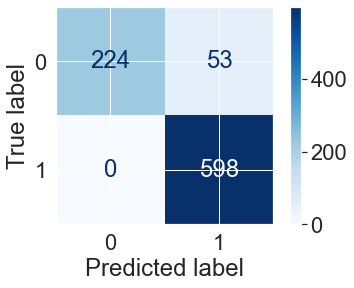

In [91]:
evaluate_model(y_test,y_hat_test,X_test,best_pipe)

In [92]:
X_train_pipe.shape

(2625, 4256)

In [93]:
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()
features[:10]

['000', '02', '03', '0310apple', '08', '10', '100', '100s', '101', '106']

In [94]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [95]:
bigram1 = pd.DataFrame(tweets_scored, columns=['Words','Freq'])
bigram1

,Words,Freq
0,"(apple, store)",0.006920
1,"(social, network)",0.005277
2,"(new, social)",0.004837
3,"(google, launch)",0.003912
4,"(link, google)",0.003877
...,...,...
42702,"(åç, complete)",0.000012
42703,"(åçwhat, tech)",0.000012
42704,"(åè, android)",0.000012
42705,"(åè, ubersoc)",0.000012


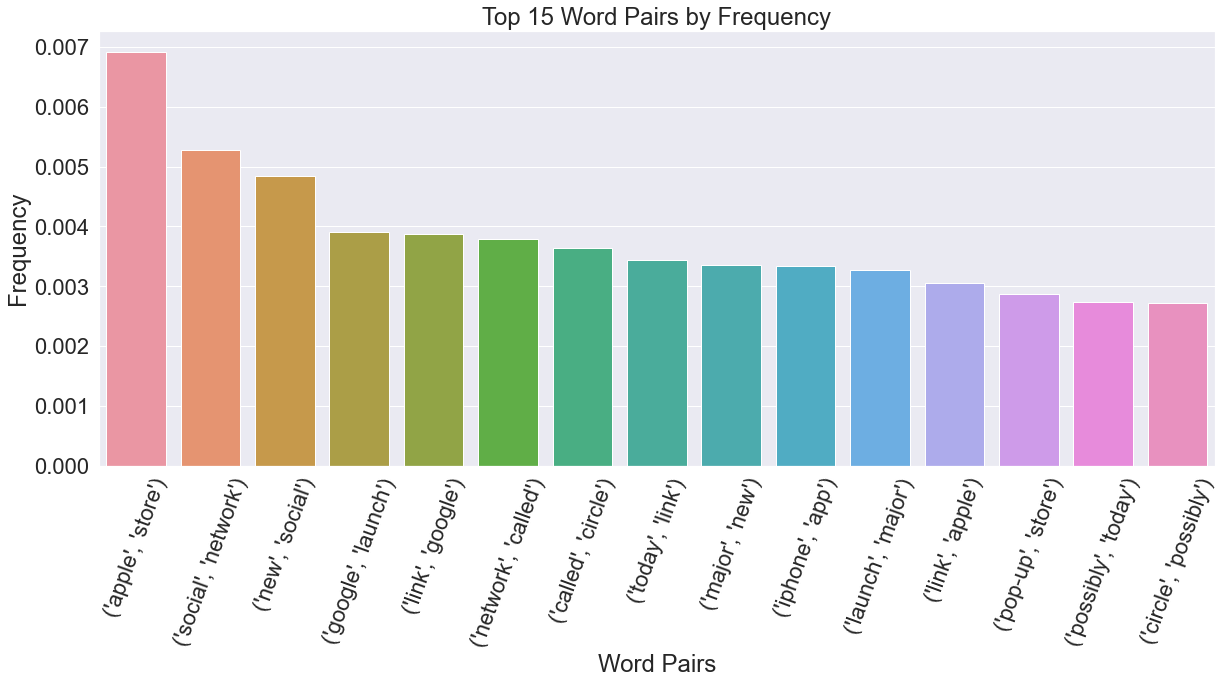

In [96]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=bigram1.head(15)['Words'], y=bigram1.head(15)['Freq'], palette=palette)
ax.set(xlabel="Word Pairs",ylabel="Frequency")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by Frequency')
plt.show() 

## Deep NLP using Keras NN

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers

In [ ]:
model = 0

In [ ]:
y = np.asarray(df_upsampled['Positive_Bin']).astype('float32').reshape((-1,1))
X = np.asarray(df_upsampled['Tweet'])

In [ ]:
X.dtype

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X))
sequences = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(sequences,maxlen=100)

In [ ]:
tokenizer.word_counts

In [ ]:
vocab_size = len(tokenizer.word_counts)
seq_len = X.shape[1]

In [ ]:
vocab_size
seq_len

In [ ]:
print(type(X),X.shape)
print(type(y),y.shape)

In [ ]:
X = np.asarray(X).astype('float32')

In [ ]:
print(type(X),X.shape)
print(type(y),y.shape)

In [ ]:
# X_train, y_train, X_test, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [ ]:
def create_model(vocab_size,seq_len):
    
    model = Sequential()
    embedding_size = 128
    model.add(Embedding(vocab_size, seq_len, input_length=seq_len))
    model.add(Dense(16,input_dim=2, activation='relu'))
    model.add(LSTM(8,input_dim=2, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['precision'])
    
    model.summary()
    
    return model

In [ ]:
model = create_model(vocab_size,seq_len)

In [ ]:
model.fit(X,y, batch_size=32, epochs=5, verbose=1, validation_split=.2)

## Deep NLP using Word2Vec NN

In [ ]:
from nltk import word_tokenize

In [ ]:
data = df_upsampled['Tweet'].map(word_tokenize)

In [ ]:
data[:10]

In [ ]:
model_W2V = Word2Vec(data, size =100, window=5, min_count=1, workers=4)

In [ ]:
model_W2V.train(data,total_examples=model_W2V.corpus_count, epochs=10)

In [ ]:
wv = model_W2V.wv

In [ ]:
wv.most_similar(positive='good')

In [ ]:
wv['help']

In [ ]:
wv.vectors

In [ ]:
wv.most_similar(positive=['apple','google'], negative = ['man'])